In [1]:
import numpy as np
import math
from scipy.special import erfc
from utils import bits_per_symbol
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs('figures', exist_ok=True)



def theoretical_ber_awgn(modulation_order: int, ebno_db: float) -> float:
    """
    Compute theoretical BER over AWGN for PSK and square QAM using union‐bound
    approximations from Goldsmith (2008) / Andrea Goldsmith.

    Parameters
    ----------
    modulation_order
        M (4 for QPSK, 8, 16, 64, ...).
    ebno_db
        Eb/N0 in dB.

    Returns
    -------
    ber : float
        Theoretical bit-error rate.
    """
    bps  = bits_per_symbol(modulation_order)
    ebno = 10**(ebno_db/10)

    # Q-function in terms of erfc: Q(x) = 0.5*erfc(x/√2)
    def Q(x):
        return 0.5 * erfc(x / math.sqrt(2))

    # --- BPSK/QPSK special case ---
    if modulation_order == 4:
        # QPSK BER = Q(√(2*Eb/N0))
        return Q(math.sqrt(2 * ebno))

    # --- M-PSK (approx) ---
    # nearest‐neighbor union‐bound: Ps ≈ 2 Q(√(2*γs) sin(π/M)),  Pb ≈ Ps/bps
    if modulation_order not in [4] and bps == 1:
        # pure PSK >4
        gamma_s = ebno * bps
        return (2 / bps) * Q(math.sqrt(2 * gamma_s) * math.sin(math.pi / modulation_order))

    # --- square M-QAM ---
    m = int(math.isqrt(modulation_order))
    if m*m == modulation_order:
        # union‐bound: Pb ≈ (4*(1 – 1/√M) / bps) * Q(√(3*γb*bps/(M−1)))
        alpha = 4 * (1 - 1/m) / bps
        beta  = 3 * bps / (modulation_order - 1)
        return alpha * Q(math.sqrt(beta * ebno))

    # fallback (treat as PSK)
    return Q(math.sqrt(2 * ebno) * math.sin(math.pi / modulation_order))


def theoretical_ber_rayleigh(
    modulation_order: int,
    ebno_db: float
) -> float:
    """
    Theoretical BER over flat Rayleigh fading channel (coherent detection).

    Uses known closed-form for BPSK/QPSK:
      BER = 0.5 * (1 - sqrt(ebno/(1+ebno))).

    For higher-order QAM/PSK, this is approximate via averaging AWGN BER over exponential distribution.

    Parameters
    ----------
    modulation_order
        M (typically 4 for QPSK/BPSK).
    ebno_db
        Eb/N0 in dB.

    Returns
    -------
    ber : float
        Theoretical bit-error rate.
    """
    ebno = 10**(ebno_db/10)
    if modulation_order == 4:
        # QPSK ~ BPSK
        return 0.5 * (1 - math.sqrt(ebno / (1 + ebno)))
    # approximate for square QAM (m>2)
    # use numeric integration or union bound – here use AWGN formula as rough estimate
    return theoretical_ber_awgn(modulation_order, ebno_db)


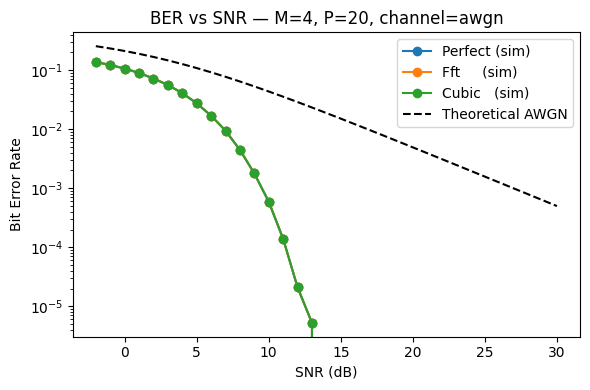

In [2]:

# 1) Read the full results table
df = pd.read_csv('BER_sweep_results_2.csv')

# 2) Pick your scenario:
#    e.g. 16-QAM, pilot_spacing=5, Rayleigh channel
mod = 4
P   = 20
channel = 'awgn'

# If it’s a Doppler scenario, you’d also filter on `scenario`:
# scenario = 'doppler_p5_v30_f700MHz'

df_s = df.query(
    'modulation == @mod and pilot_spacing == @P and channel == @channel'
)

# 3) Pivot so SNR is index, methods are columns, values are BER
ber_tbl = df_s.pivot(
    index='snr_db',
    columns='method',    # perfect, fft, cubic
    values='ber'
).sort_index()

# 4) Plot the simulated curves
plt.figure(figsize=(6,4))
for method in ['perfect','fft','cubic']:
    if method in ber_tbl:
        plt.semilogy(
            ber_tbl.index,
            ber_tbl[method],
            marker='o',
            label=f'{method.capitalize():<7} (sim)'
        )

# 5) Overlay the theoretical BER curve (if available)
#    For Rayleigh‐faded 16-QAM with ZF, you might use an approximate formula:
#    Pb ≈ (4/np.log2(M))*(1 - 1/np.sqrt(M)) * 0.5*(1 - np.sqrt(snr/(1+snr)))
#    Here’s a quick example for 16-QAM over AWGN:
if channel == 'awgn':
    snr_lin = 10**(ber_tbl.index/10)
    M = mod
    # Gray‐coded 16-QAM BER approximation over AWGN:
    Pb = (4*(1 - 1/np.sqrt(M)) / np.log2(M)) * \
         0.5 * (1 - np.sqrt( (3*snr_lin) / (2*(M-1) + 3*snr_lin) ))
    plt.semilogy(ber_tbl.index, Pb, linestyle='--', color='k', label='Theoretical AWGN')


plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.title(f'BER vs SNR — M={mod}, P={P}, channel={channel}')
plt.legend()
plt.tight_layout()
plt.show()


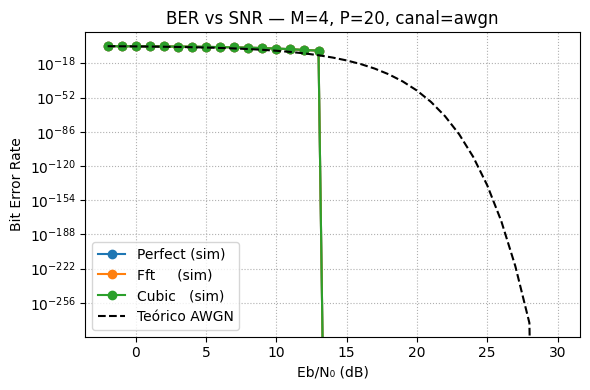

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erfc

# 1) Leer la tabla completa
df = pd.read_csv('BER_sweep_results_2.csv')

# 2) Elegir escenario
mod     = 4
P       = 20
channel = 'awgn'

df_s = df.query(
    'modulation == @mod and pilot_spacing == @P and channel == @channel'
)

# 3) Pivotear para tener SNR en el índice y métodos como columnas
ber_tbl = df_s.pivot_table(
    index='snr_db',
    columns='method',    # perfect, fft, cubic
    values='ber'
).sort_index()

# 4) Graficar curvas simuladas
plt.figure(figsize=(6,4))
for method in ['perfect','fft','cubic']:
    if method in ber_tbl.columns:
        plt.semilogy(
            ber_tbl.index,
            ber_tbl[method],
            marker='o',
            label=f'{method.capitalize():<7} (sim)'
        )

# 5) Superponer BER teórica AWGN
if channel == 'awgn':
    ebno_db  = ber_tbl.index.values
    ebno_lin = 10**(ebno_db/10)

    if mod == 4:
        # QPSK: BER = 0.5 * erfc(sqrt(Eb/N0))
        theo = 0.5 * erfc(np.sqrt(ebno_lin))
    else:
        # M-QAM: primero convertir Eb/N0 -> Es/N0
        bps      = np.log2(mod)
        esno_lin = ebno_lin * bps
        # union‐bound approximation en términos de Es/N0
        alpha = 4*(1 - 1/np.sqrt(mod)) / bps
        beta  = 3*bps/(mod - 1)
        theo  = alpha * 0.5 * erfc(np.sqrt(beta * esno_lin))

    plt.semilogy(
        ebno_db, theo,
        linestyle='--',
        color='k',
        label='Teórico AWGN'
    )

plt.xlabel('Eb/N₀ (dB)')
plt.ylabel('Bit Error Rate')
plt.title(f'BER vs SNR — M={mod}, P={P}, canal={channel}')
plt.legend()
plt.grid(which='both', ls=':')
plt.tight_layout()
plt.show()


In [4]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asumimos que ya has hecho:
# df = pd.read_csv('BER_sweep_results_3.csv')

modulations    = [4, 16]
pilot_spacings = [5, 10, 20]
channels       = ['awgn', 'rayleigh']
doppler_tags   = sorted(df.loc[df.channel=='doppler','scenario'].unique())
all_channels   = channels + doppler_tags

for M in modulations:
    B = int(math.log2(M))       # bits por símbolo
    for P in pilot_spacings:
        for channel in all_channels:
            # Filtrado por canal o escenario Doppler
            if channel in channels:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and channel == @channel'
                )
                label = channel
            else:
                df_s = df.query(
                    'modulation == @M and pilot_spacing == @P and scenario == @channel'
                )
                label = channel

            if df_s.empty:
                continue

            # Pivot: index=Es/N0 (dB), columnas=method, valores=BER
            ber_tbl = df_s.pivot_table(
                index='snr_db',
                columns='method',
                values='ber'
            ).sort_index()

            EsN0_db = ber_tbl.index.values
            EbN0_db = EsN0_db - 10*np.log10(B)   # conversión a Eb/N0

            plt.figure(figsize=(6,4))

            # 1) Simuladas vs Eb/N0
            for method in ['perfect','fft','cubic']:
                if method in ber_tbl.columns:
                    plt.semilogy(
                        EbN0_db,
                        ber_tbl[method].values,
                        marker='o',
                        label=f'{method.capitalize()} (sim)'
                    )

            # 2) Teóricas vs Eb/N0
            if channel == 'awgn':
                # teórica AWGN (usa Eb/N0 directamente)
                ebno_lin = 10**(EbN0_db/10)
                if M == 4:
                    # QPSK
                    theo = 0.5 *  erfc(np.sqrt(ebno_lin))
                else:
                    # M-QAM, union‐bound aproximado
                    alpha = 4*(1 - 1/np.sqrt(M)) / B
                    beta  = 3*B/(M-1)
                    theo  = alpha * 0.5 * erfc(np.sqrt(beta * ebno_lin))
                plt.semilogy(
                    EbN0_db, theo,
                    '--k', label='Teórico AWGN'
                )

            elif channel == 'rayleigh':
                # teórica Rayleigh
                ebno_lin = 10**(EbN0_db/10)
                if M == 4:
                    theo_ray = 0.5*(1 - np.sqrt(ebno_lin/(1+ebno_lin)))
                else:
                    theo_ray = [theoretical_ber_rayleigh(M, eb) for eb in EbN0_db]
                plt.semilogy(
                    EbN0_db, theo_ray,
                    '--k', label='Teórico Rayleigh'
                )

            plt.grid(which='both', ls=':')
            plt.xlabel('$E_b/N_0$ (dB)')
            plt.ylabel('Bit Error Rate')
            plt.title(f'M={M}, P={P}, canal={label}')
            plt.legend()
            plt.tight_layout()

            # Guardar
            outpath = os.path.join('figures',
                                   f'BER_{label}_P{P}_M{M}.pdf')
            plt.savefig(outpath)
            plt.close()
            print(f'→ escrito {outpath}')


→ escrito figures/BER_awgn_P5_M4.pdf
→ escrito figures/BER_rayleigh_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500MHz_P5_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f700MHz_P5_M4.pdf
→ escrito figures/BER_awgn_P10_M4.pdf
→ escrito figures/BER_rayleigh_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p40_v30_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f3500MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v120_f700MHz_P10_M4.pdf
→ escrito figures/BER_doppler_p5_v30_f3500M

In [5]:
from plots import plot_unequalized, plot_equalized

if __name__ == "__main__":
    # Parámetros globales
    modulations    = [4, 16]
    pilot_spacings = [5, 10, 20]
    snr_list       = [-5, 0, 10, 30]       # los 4 SNRs para las 2×2
    n_bits         = 100_000
    doppler_params = {
        'paths':       [5, 40],
        'speed_kmh':   [30, 120],
        'carrier_freq':[700e6, 3.5e9]
    }
    rng = np.random.default_rng(1234)

    for M in modulations:
        for P in pilot_spacings:
            # primero AWGN y Rayleigh (sin parámetros extra)
            for model in ['awgn', 'rayleigh']:
                print(f"=== M={M}, P={P}, canal={model} ===")
                plot_unequalized(
                    modulation_order=M,
                    model=model,
                    snr_list=snr_list,
                    n_bits=n_bits,
                    pilot_spacing=P,
                    rng=rng
                )
                plot_equalized(
                    modulation_order=M,
                    model=model,
                    snr_list=snr_list,
                    n_bits=n_bits,
                    pilot_spacing=P,
                    rng=rng
                )

            # ahora Doppler: barremos todas las combinaciones (paths, speed, freq)
            for paths in doppler_params['paths']:
                for speed in doppler_params['speed_kmh']:
                    for freq in doppler_params['carrier_freq']:
                        tag = f"doppler_p{paths}_v{speed}_f{int(freq/1e6)}MHz"
                        print(f"=== M={M}, P={P}, canal={tag} ===")
                        # en las funciones pasamos model='doppler' y les damos los parámetros
                        plot_unequalized(
                            modulation_order=M,
                            model='doppler',
                            snr_list=snr_list,
                            n_bits=n_bits,
                            pilot_spacing=P,
                            paths=paths,
                            speed_kmh=speed,
                            carrier_freq=freq,
                            rng=rng
                        )
                        plot_equalized(
                            modulation_order=M,
                            model='doppler',
                            snr_list=snr_list,
                            n_bits=n_bits,
                            pilot_spacing=P,
                            paths=paths,
                            speed_kmh=speed,
                            carrier_freq=freq,
                            rng=rng
                        )

=== M=4, P=5, canal=awgn ===
Saved unequalized plot to constellations/4_awgn_P5_unequalized.png
Saved equalized plot to constellations/4_awgn_P5_equalized.png
=== M=4, P=5, canal=rayleigh ===
Saved unequalized plot to constellations/4_rayleigh_P5_unequalized.png
Saved equalized plot to constellations/4_rayleigh_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v30_f700MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v30kmh_f700MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v30kmh_f700MHz_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v30_f3500MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v30kmh_f3500MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v30kmh_f3500MHz_P5_equalized.png
=== M=4, P=5, canal=doppler_p5_v120_f700MHz ===
Saved unequalized plot to constellations/4_doppler_p5_v120kmh_f700MHz_P5_unequalized.png
Saved equalized plot to constellations/4_doppler_p5_v120kmh_f700MHz_P5_equalized.png
=== M=4

/tmp/ipykernel_21345/893013776.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', M)


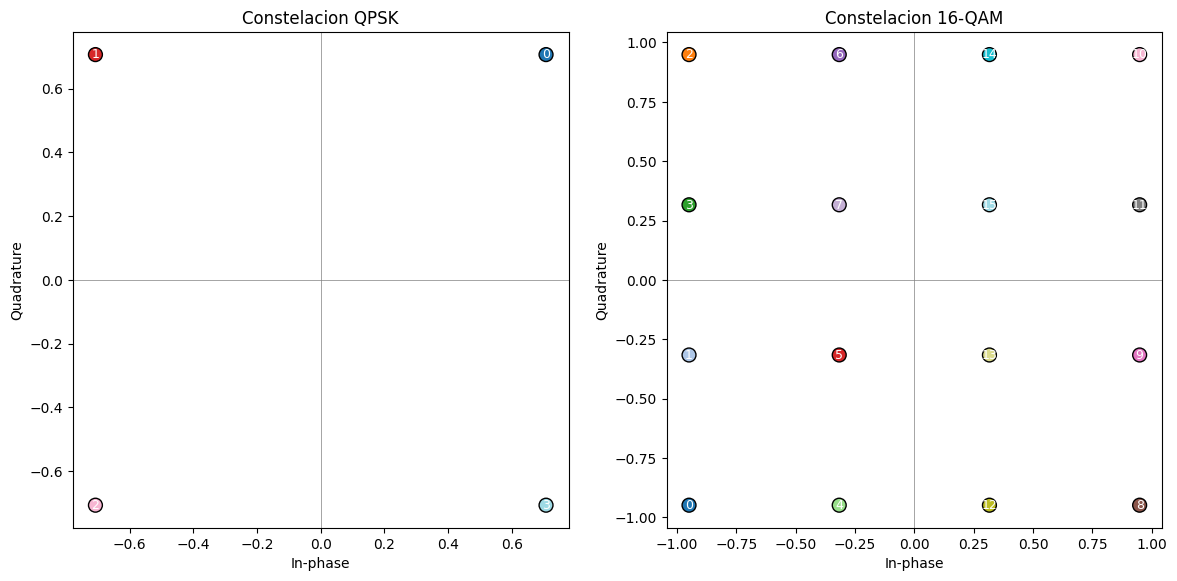

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from transmitter import modulate_sequence  # Asegúrate de que QPSK y QAM16 estén disponibles aquí

# Parámetros
mods   = [4, 16]
titles = ["Constelacion QPSK", "Constelacion 16-QAM"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, M, title in zip(axes, mods, titles):
    # Índices de símbolo
    indices = np.arange(M)
    # Puntos de la constelación
    tx = modulate_sequence(indices, M)

    # Misma paleta que antes
    cmap = plt.cm.get_cmap('tab20', M)
    norm = mcolors.BoundaryNorm(np.arange(M+1)-0.5, M)
    
    # Dibujar
    ax.scatter(
        tx.real, tx.imag,
        c=indices, cmap=cmap, norm=norm,
        s=100, edgecolors='k'
    )
    ax.set_title(title)
    ax.set_xlabel("In‐phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_aspect('equal', 'box')
    # Etiquetar cada punto con su índice
    for idx, point in zip(indices, tx):
        ax.text(
            point.real, point.imag, str(idx),
            ha='center', va='center',
            fontsize=9, color='white'
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_21345/594552528.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', M)


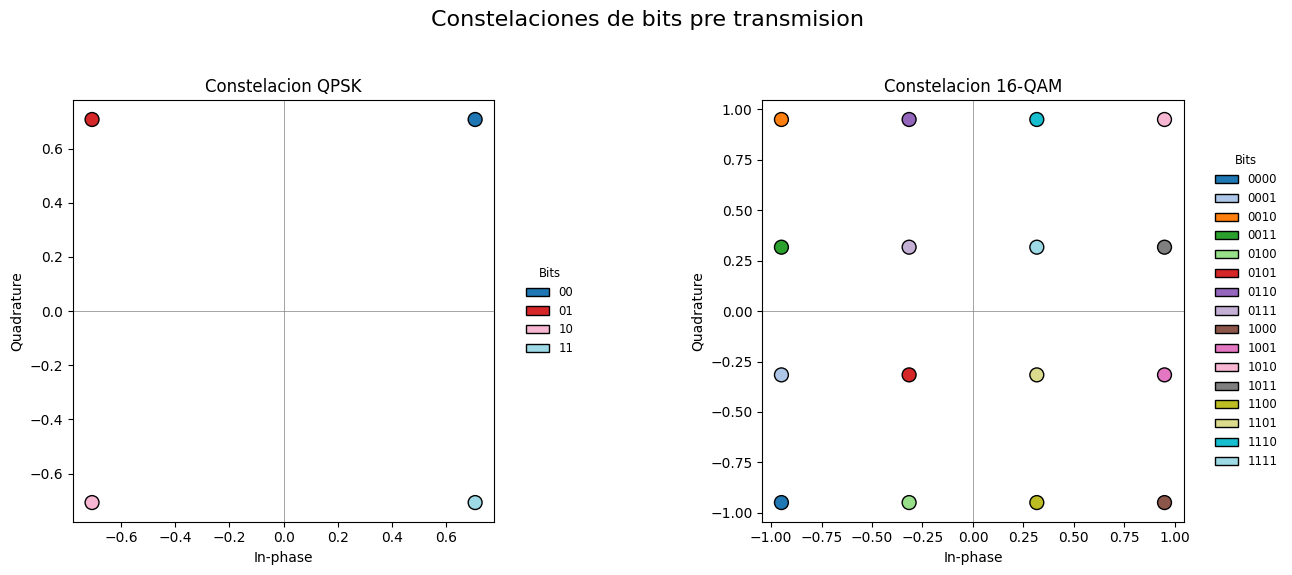

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from transmitter import modulate_sequence  # Aquí importa tu función de modulador

mods   = [4, 16]
titles = ["Constelacion QPSK", "Constelacion 16-QAM"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, M, title in zip(axes, mods, titles):
    indices = np.arange(M)
    bps = int(np.log2(M))
    tx = modulate_sequence(indices, M)

    cmap = plt.cm.get_cmap('tab20', M)
    norm = mcolors.BoundaryNorm(np.arange(M+1)-0.5, M)
    
    ax.scatter(tx.real, tx.imag, c=indices, cmap=cmap, norm=norm,
               s=100, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("In‐phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_aspect('equal', 'box')

    # Construir leyenda: parches coloreados con la cadena de bits
    handles = []
    for idx in indices:
        color = cmap(norm(idx))
        bitstr = format(idx, f'0{bps}b')
        patch = mpatches.Circle((0,0), radius=0.1, facecolor=color,
                                edgecolor='k', label=bitstr)
        handles.append(patch)

    ax.legend(handles=handles, title="Bits",
              loc='center left', bbox_to_anchor=(1.05, 0.5),
              frameon=False, fontsize='small', title_fontsize='small')

plt.suptitle("Constelaciones de bits pre-transmision", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
